In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [3]:
%matplotlib inline

import pandas as pd
from aeps import AEP_metrics_lims
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from spiketrain import inst_rate, get_shuffled
from population import unit_response_matrix, spontaneous_activity

np.set_printoptions(suppress=True)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions[:2]

['009266_hippoSIT_2023-04-17_17-04-17', '009266_hippoSIT_2023-04-18_10-10-37']

In [5]:
session = sessions[4]
session

'009266_hippoSIT_2023-04-20_08-57-39'

## Unit / population slow timescale

In [6]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
rep_path = '/home/sobolev/nevermind/Andrey/analysis/reporting'

animal   = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')
aeps_file  = os.path.join(dst_path, animal, session, 'AEPs.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])

aeps = {}
with h5py.File(aeps_file, 'r') as f:
    for area in f:
        ds_name = [x for x in f[area]][0]
        aeps[area] = np.array(f[area][ds_name])
        
single_units, spike_times = {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

In [7]:
area = 'A1'
sel_unit = list(single_units.keys())[0]
sel_unit = '3-15'

### Population 1

In [8]:
# based on W4 population activity matrix
s_path = os.path.join(dst_path, animal, session)
s_act  = spontaneous_activity(s_path)

# speed!
speed_min = 0.04
sound_event = 1
idxs_sel_events  = np.where(sound_events[:, 1] == sound_event)[0]  # idxs to SE
idxs_idle_events = np.where(tl[sound_events[:, 2].astype(np.int32)][:, 3] < speed_min)[0]  # idxs to SE
idxs_bgr_macro = np.intersect1d(idxs_sel_events, idxs_idle_events)

idxs_sel_tl  = sound_events[sound_events[:, 1] == sound_event][:, 2].astype(np.int32)  # idxs to TL
idxs_idle_tl = np.where(tl[:, 3] < speed_min)[0]  # idxs to TL
idxs_bgr_tl  = np.intersect1d(idxs_sel_tl, idxs_idle_tl)
unit_act1    = stats.zscore(inst_rate(spike_times[sel_unit], tl[:, 0], k_width=1000)[idxs_bgr_tl])
speed        = tl[idxs_bgr_tl][:, 3]

pop_act1 = s_act[idxs_bgr_macro]
pop_act1.shape, unit_act1.shape, speed.shape

((3821,), (3821,), (3821,))

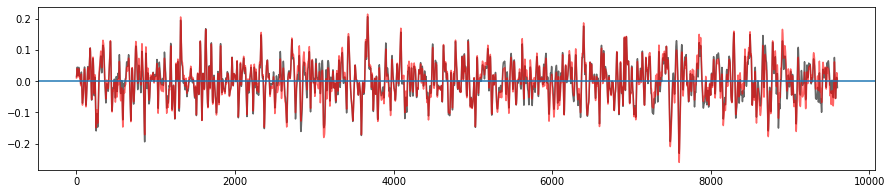

In [28]:
# filter slow oscillations
s_rate, low_cut, high_cut = 4, 0.1, 50  # Hz
#sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], fs=4, analog=False, btype='highpass', output='sos')
sos = signal.butter(10, 0.01, fs=4, analog=False, btype='highpass', output='sos')
pop_act3 = signal.sosfiltfilt(sos, s_act)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(pop_act3, label='W4 pop. activity', color='black', alpha=0.6)
ax.plot(s_act, label='W4 pop. activity', color='red', alpha=0.6)
#ax.set_xlim(2000, 4000)
ax.axhline(0)

### Population 2

In [40]:
# population activity matrix - timeline binning
unit_names = [name for name in single_units.keys() if int(name[0]) < 3]
unit_mx2 = np.zeros([len(tl), len(unit_names)])
for i, unit_id in enumerate(unit_names):
    #unit_mx[:, i] = stats.zscore(single_units[unit_id])
    unit_mx2[:, i] = stats.zscore(inst_rate(spike_times[unit_id], tl[:, 0], k_width=500))

# select all
speed_min = 0.04
sound_event = 1
idxs_micro = np.where(tl[:, 6] == 0)[0]
idxs_idle  = np.where(tl[:, 3] < 0.04)[0]
idxs_selected = np.intersect1d(idxs_micro, idxs_idle)

pca = decomposition.PCA(n_components=3)
#pca.fit(unit_mx[np.intersect1d(idxs_sil_micro_all, idxs_idle)])
#X = pca.transform(unit_mx[np.intersect1d(idxs_sil_micro_all, idxs_idle)])
pca.fit(unit_mx2)
X = pca.transform(unit_mx2)
pop_act2 = X[:, 0][idxs_selected]

#pop_act  = unit_mx.mean(axis=1)[idxs_selected]
#pop_act  = (unit_mx*pca.components_[0]).mean(axis=1)[idxs_selected]

unit_act2 = stats.zscore(inst_rate(spike_times[sel_unit], tl[:, 0], k_width=1000)[idxs_selected])

pop_act2.shape, unit_act2.shape, pca.components_[0]

((45303,), (45303,), array([0.5342544 , 0.61984458, 0.49343876, 0.29475943]))

### shuffle

In [81]:
# Try to see if shuffling changes timing of states
unit_mx_shuf = np.zeros([len(tl), len(unit_names)])
for i, unit_id in enumerate(unit_names):
    spk_shuf = get_shuffled(spike_times[unit_id])
    unit_mx_shuf[:, i] = stats.zscore(inst_rate(spk_shuf, tl[:, 0], k_width=1000))
    
pca = decomposition.PCA(n_components=3)
pca.fit(unit_mx_shuf)
Y = pca.transform(unit_mx_shuf)
pop_act_shuf  = Y[:, 0][idxs_selected]

In [9]:
# compute correlation 
corr_pop1, pval_p1 = stats.pearsonr(pop_act1, unit_act1)
#corr_pop2, pval_p2 = stats.pearsonr(pop_act2, unit_act2)
corr_speed, pval_s = stats.pearsonr(speed, unit_act1)
print("Population: %.2f (%.5f); Speed: %.2f (%.5f)" % (corr_pop1, pval_p1, corr_speed, pval_s))
#print("Population: %.2f (%.5f); Speed: %.2f (%.5f)" % (corr_pop2, pval_p2, corr_speed, pval_s))

Population: -0.63 (0.00000); Speed: -0.36 (0.00000)


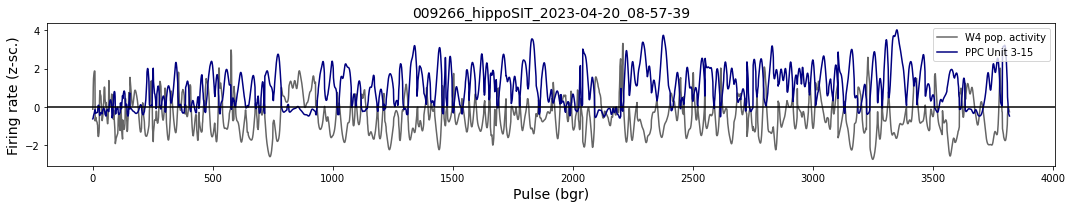

In [35]:
# TODO plot this together with histogram for all sessions

p_type = 'bgr'

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(5*pop_act1, label='W4 pop. activity', color='black', alpha=0.6)
ax.plot(unit_act1 + 1, label='PPC Unit %s' % sel_unit, color='navy')
#ax.plot(unit_act2[::12] + 2, label='PPC Unit %s' % sel_unit)
ax.set_ylabel('Firing rate (z-sc.)', fontsize=14)
ax.set_xlabel('Pulse (%s)' % p_type, fontsize=14)
ax.set_title(session, fontsize=14)
#ax.plot(pop_act_shuf, label='Shuffle')
ax.axhline(0, color='black')
ax.legend(loc='upper right')
#ax.plot(3*speed-5)
#ax.set_xlim(1000, 2000)
#ax.axhline(pop_act_shuf.std())
fig.tight_layout()

#fig.savefig(os.path.join(rep_path, '%s_pop_unit_%s.png' % (session[-19:-9], p_type)), dpi=1000)

(array([9., 6., 0., 0., 3., 1., 1., 1., 3., 2., 1., 1., 1., 1., 2., 0., 1.,
        1., 1., 1.]),
 array([  3.  ,  34.85,  66.7 ,  98.55, 130.4 , 162.25, 194.1 , 225.95,
        257.8 , 289.65, 321.5 , 353.35, 385.2 , 417.05, 448.9 , 480.75,
        512.6 , 544.45, 576.3 , 608.15, 640.  ]),
 <BarContainer object of 20 artists>)

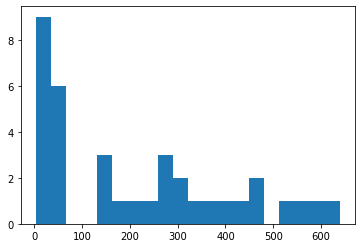

In [84]:
periods      = np.diff(np.where(pop_act < -0.5*pop_act.std())[0])
periods_shuf = np.diff(np.where(pop_act_shuf < -0.5*pop_act_shuf.std())[0])
collected = []
count = 0
for p in periods:
    if p == 1:
        count += 1
    else:
        collected.append(int(count))
        count = 0
        
plt.hist(collected, bins=20)

0
1
2
3
4


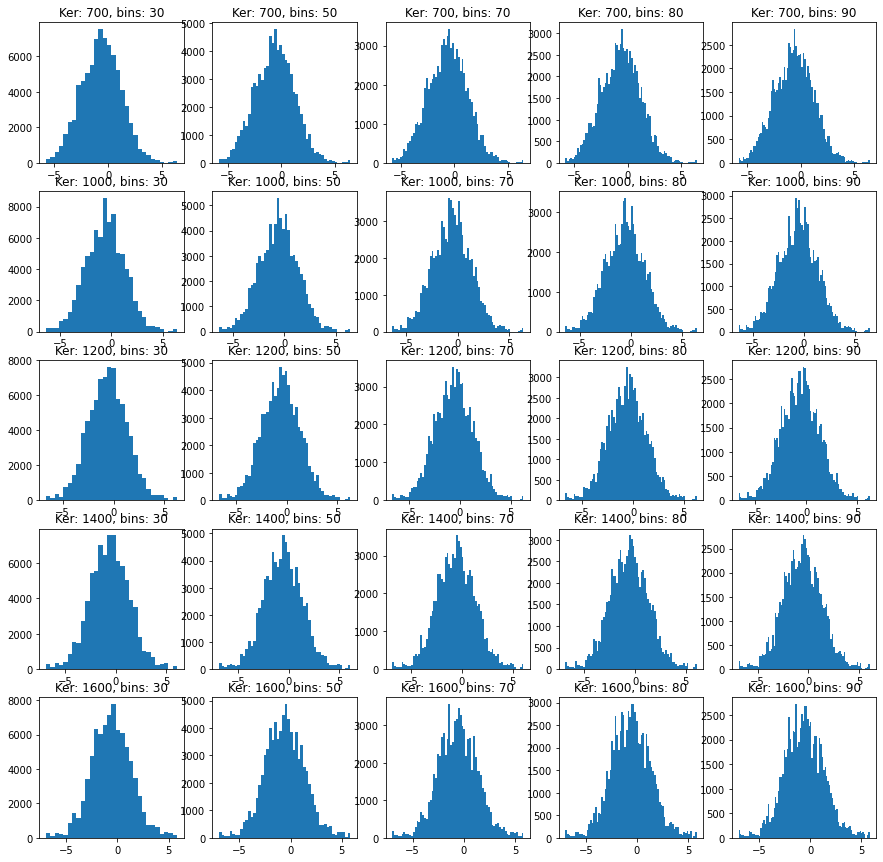

In [85]:
kernels    = [700, 1000, 1200, 1400, 1600]
counts     = [30, 50, 70, 80, 90]
unit_names = [name for name in single_units.keys() if int(name[0]) < 3]
idxs_micro = np.where(tl[:, 6] == 1)[0]
idxs_idle = np.where(tl[:, 3] < 0.04)[0]
idxs = np.intersect1d(idxs_micro, idxs_idle)

fig = plt.figure(figsize=(15, len(kernels)*3))

for i, ker_size in enumerate(kernels):
    unit_mx = np.zeros([len(tl), len(unit_names)])
    for k, unit_id in enumerate(unit_names):
        #spikes = get_shuffled(spike_times[unit_id])
        spikes = spike_times[unit_id]
        i_rate = inst_rate(spikes, tl[:, 0], k_width=ker_size)
        unit_mx[:, k] = stats.zscore(i_rate)
        
    pca = decomposition.PCA(n_components=3)
    pca.fit(unit_mx)
    X = pca.transform(unit_mx)

    for j, bin_count in enumerate(counts):
        ax = fig.add_subplot(len(kernels), len(counts), i*len(counts) + j + 1)
        ax.hist(X[idxs][:, 0], bins=bin_count)
        ax.set_title("Ker: %s, bins: %s" % (ker_size, bin_count))
        
    print(i)

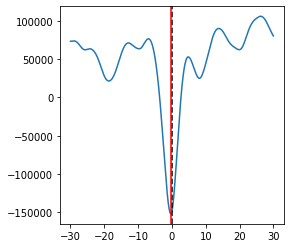

In [120]:
s_rate = 100  # Hz, timeline sampling
t_lag = 30  # in seconds
corr = signal.correlate(pop_act, unit_act, mode='same')

idx_l, idx_r = int(len(corr)/2) - t_lag*s_rate, int(len(corr)/2) + t_lag*s_rate
x_vals = np.linspace(-t_lag, t_lag, idx_r - idx_l)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x_vals, corr[idx_l:idx_r])
ax.axvline(0, color='black', ls='--')
ax.axvline(x_vals[corr[idx_l:idx_r].argmin()], color='red')
#ax.set_xlim(-t_lag, t_lag)
#ax.set_ylim(y_min, y_max)

(135929,)

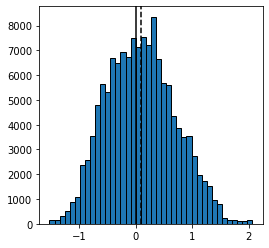

In [121]:
# TODO move to the plot up
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

_ = ax.hist(pop_act, bins=40, edgecolor='black')
ax.axvline(0, color='black')
ax.axvline(pop_act.mean(), color='black', ls='--')
pop_act.shape

In [122]:
# 1. Check that sum of all 6 phases correlates with pop response computed as an inst. rate and 
# also anti-correlates with AL units
# 2. Check how individual phases correlate with population response (P1 should be anti-correlated, the rest opposite)
# 3. If 2 is true, correlate only sum of N1-P3 phases with AL unit - should be better correlation
# 4. Include GLM weights when computing pop response. Does it change much?
# 5. play with smoothing of AL unit / pop response to maybe get better results on slower time-scales


# Questions:
# 1. How to correctly compute pop activity matrix? Now its a mean of z-scored i-rate of each unit.
# 2. How to exclude speed / distance to speaker / head direction from the dependencies?
# 3. Gamma-band sync. How to correctly compute correlation bw pop activity and gamma-band freq? 

In [320]:
resp_mx = unit_response_matrix(session, 'A1')
pop_response = {}
for i, (m_name, m_lims) in enumerate(AEP_metrics_lims[area].items()):
    resp_at_phase = resp_mx[i+1::6].T
    for j, unit_data in enumerate(resp_at_phase):
        resp_at_phase[j] = stats.zscore(unit_data)
    pop_response[m_name] = resp_at_phase.T.mean(axis=1)
    
    # smooth
    k_width = 20
    kernel = signal.gaussian(k_width, std=(k_width) / 7.2)
    pop_response[m_name] = np.convolve(pop_response[m_name], kernel, 'same') / kernel.sum()

(0.4754946015605615, 6.452445118934346e-305)
(-0.11607088157535585, 8.969100464277916e-18)


(1000.0, 2000.0)

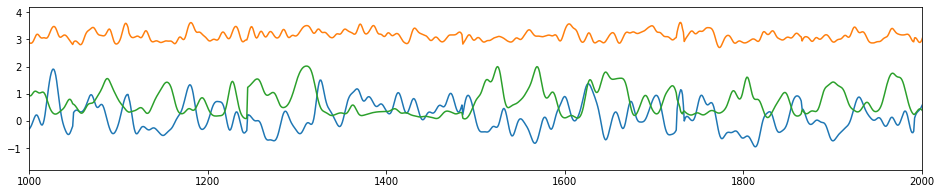

In [332]:
idxs_bgr_aep = np.where(sound_events[:, 1] == 1)[0]
idxs_bgr_tl  = sound_events[idxs_bgr_aep][:, 2].astype(np.int32)


pop_from_all = unit_mx[idxs_bgr_tl].mean(axis=1)
pop_at_phase = pop_response['P1'][idxs_bgr_aep]
unit_response = single_units['3-15'][idxs_bgr_tl]/10

print(stats.pearsonr(pop_from_all, pop_at_phase))
print(stats.pearsonr(unit_response, pop_at_phase))

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(pop_from_all)
ax.plot(pop_at_phase + 3)
ax.plot(unit_response)
ax.set_xlim(1000, 2000)

## AEP shape at diff states

In [185]:
# TODO for all sessions

area = 'A1'
idxs_bgr_aep = np.where(sound_events[:, 1] == 1)[0]
idxs_bgr_tl  = sound_events[idxs_bgr_aep][:, 2].astype(np.int32)

pop_act = unit_mx.mean(axis=1)[idxs_bgr_tl]
idxs_aep_high = np.where(pop_act > pop_act.mean() + 0.2*pop_act.std())[0]
idxs_aep_low  = np.where(pop_act < pop_act.mean() - 0.2*pop_act.std())[0]

len(idxs_aep_high), len(idxs_aep_low), sound_events[idxs_bgr_aep].shape

(2298, 2427, (5533, 3))

Text(0, 0.5, 'LFP, uV')

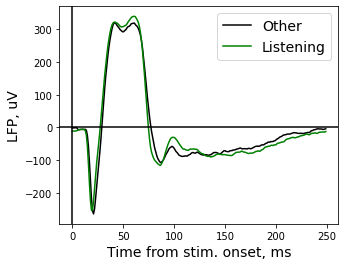

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(aeps[area][idxs_bgr_aep][idxs_aep_high].mean(axis=0) * 0.2, color='black', label='Other')  # 0.2 OpenEphys scaling factor
ax.plot(aeps[area][idxs_bgr_aep][idxs_aep_low].mean(axis=0) * 0.2, color='green', label='Listening')  # 0.2 OpenEphys scaling factor
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.legend(loc='upper right', prop={'size': 14})
ax.set_xlabel('Time from stim. onset, ms', fontsize=14)
ax.set_ylabel('LFP, uV', fontsize=14)

## Separately - diff phases (P1, N1, P2, P3)

## Smoothing calibration

In [510]:
k_sizes = 300 * (np.arange(10) + 1)

# matrix of unit with diff smoothing
sel_unit = '3-18'
unit_i_rates = np.zeros([len(tl), len(k_sizes)])
for i, k_size in enumerate(k_sizes):
    unit_i_rates[:, i] = inst_rate(spike_times[sel_unit], tl[:, 0], k_width=k_size)

# matrix of A1 population PCA score with diff smoothing
pop_i_rates = np.zeros([len(tl), len(k_sizes)])
unit_names = [name for name in single_units.keys() if int(name[0]) < 3]
for i, k_size in enumerate(k_sizes):
    unit_mx = np.zeros([len(tl), len(unit_names)])
    for j, unit_id in enumerate(unit_names):
        unit_mx[:, j] = stats.zscore(inst_rate(spike_times[unit_id], tl[:, 0], k_width=k_size))
        
    pca = decomposition.PCA(n_components=3)
    pca.fit(unit_mx)
    X = pca.transform(unit_mx)
    
    pop_i_rates[:, i] = X[:, 0]
    
# build corr matrices
idxs_idle = np.where(tl[:, 3] < 0.04)[0]
idxs_sil  = np.where(tl[:, 6] == 0)[0]
idxs_bgr  = np.where(tl[:, 6] == 1)[0]
idxs_tgt  = np.where(tl[:, 6] == 2)[0]
idxs_sil = np.intersect1d(idxs_sil, idxs_idle)
idxs_bgr = np.intersect1d(idxs_bgr, idxs_idle)
idxs_tgt = np.intersect1d(idxs_tgt, idxs_idle)

# TODO: try to remove speed by interset with idle

corr_sil = np.zeros([len(k_sizes), len(k_sizes)])
corr_bgr = np.zeros([len(k_sizes), len(k_sizes)])
corr_tgt = np.zeros([len(k_sizes), len(k_sizes)])
for i, k_size_a in enumerate(k_sizes):
    for j, k_size_b in enumerate(k_sizes):
        corr_sil[i, j], _ = stats.pearsonr(pop_i_rates[:, i][idxs_sil], unit_i_rates[:, j][idxs_sil])
        corr_bgr[i, j], _ = stats.pearsonr(pop_i_rates[:, i][idxs_bgr], unit_i_rates[:, j][idxs_bgr])
        corr_tgt[i, j], _ = stats.pearsonr(pop_i_rates[:, i][idxs_tgt], unit_i_rates[:, j][idxs_tgt])

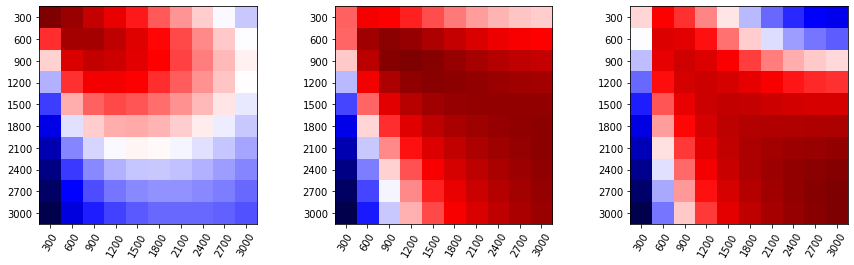

In [511]:
fig = plt.figure(figsize=(15, 4))

for i, corr_mx in enumerate([corr_sil, corr_bgr, corr_tgt]):
    ax = fig.add_subplot(1, 3, i+1)
    im = ax.imshow(np.abs(corr_mx), cmap='seismic')
    ax.set_xticks(range(corr_mx.shape[1]))
    ax.set_xticklabels(k_sizes, rotation=60)
    ax.set_yticks(range(corr_mx.shape[0]))
    _ = ax.set_yticklabels(k_sizes)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #fig.colorbar(im, cax=cax, orientation='vertical')
    #ax.set_title('Metric correlations %s' % titles[i], fontsize=14)
    #ax.set_title('Corr. coef. %s' % session[-14:], fontsize=14)
    #for p in range(corr_pearson.shape[0]):
    #    for q in range(corr_pearson.shape[1]):
    #        ax.text(p - 0.2, q, '%.2f' % corr_pearson[p, q], color='white')

In [514]:
corr_bgr[2,2]

-0.49750549949475276

(100.0, 200.0)

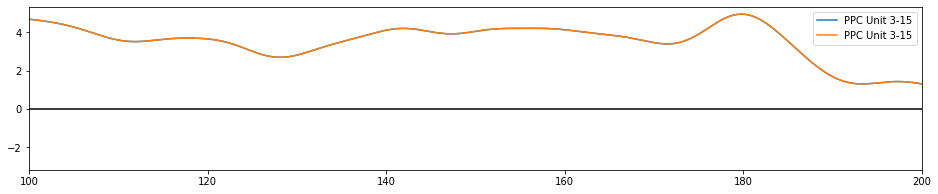

In [509]:
x_vals = tl[:, 0]

#i1 = inst_rate(spike_times[sel_unit], tl[:, 0], k_width=500)
#i2 = inst_rate(spike_times[sel_unit], tl[:, 0], k_width=1500)

i1 = pop_i_rates[:, 8]
i2 = pop_i_rates[:, 8]

fig, ax = plt.subplots(1, 1, figsize=(16, 3))
#ax.plot(pop_act, label='A1 pop. activity')
#ax.plot(X[:, 0][idxs_selected] - 1, label='A1 score')
#ax.plot(x_vals, unit_act, label='PPC Unit %s' % sel_unit)
ax.plot(x_vals, i1, label='PPC Unit %s' % sel_unit)
ax.plot(x_vals, i2, label='PPC Unit %s' % sel_unit)

ax.axhline(0, color='black')
ax.legend(loc='upper right')
ax.set_xlim(100, 200)
